# Experiment Design: Active Remediation of Clogged Wells via Hydrodynamic Waveforms

**Objective:** Investigate the efficacy of **Bio-Mimetic Pulsatile Flushing** in restoring injectivity after severe salt clogging, compared to traditional Constant-Rate Flushing.

## The "Flush & Revive" Protocol
The simulation is divided into three distinct operational phases:

1.  **Phase I: Induced Clogging ($0 < t < 1500$)**
    * **Input:** Supersaturated Brine ($C_{in} = 0.45$).
    * **Flow:** Constant Pressure.
    * **Outcome:** Rapid precipitation and loss of injectivity.

2.  **Phase II: The Cleanup ($1500 \le t < 3500$)**
    * **Input:** Undersaturated "Fresh" Water ($C_{in} = 0.0$).
    * **Variable:** 
        * *Control:* Constant Flow Flush.
        * *Test:* **Bio-Mimetic Pulsatile Flush** (Designed to enhance shear erosion).

3.  **Phase III: Resumption ($3500 \le t \le 5000$)**
    * **Input:** Supersaturated Brine ($C_{in} = 0.45$).
    * **Outcome:** Evaluate the recovered injectivity index.

In [8]:
import jax
import jax.numpy as jnp
from jax import jit, lax
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Enable 64-bit precision
jax.config.update("jax_enable_x64", True)

# --- CONFIGURATION ---
NX, NY = 200, 60
MAX_STEPS = 5000
TAU = 0.9
C_EQ = 0.35            # Solubility Limit
PRECIP_RATE = 0.05     # Rate of crystallization
DISSOLVE_RATE = 0.08   # Rate of dissolution (Cleaning is usually faster than forming)

# Lattice Constants (D2Q9)
CX = jnp.array([0, 1, 0, -1, 0, 1, -1, -1, 1])
CY = jnp.array([0, 0, 1, 0, -1, 1, 1, -1, -1])
W = jnp.array([4/9, 1/9, 1/9, 1/9, 1/9, 1/36, 1/36, 1/36, 1/36])

## 2. The Physics Engine: Reversible Precipitation

We modify the physics kernel to support **Dissolution**. 
* If $C_{salt} > C_{eq}$: Precipitation ($d\phi > 0$).
* If $C_{salt} < C_{eq}$: Dissolution ($d\phi < 0$), provided solid mass exists.

In [9]:
@jax.jit
def equilibrium(rho, u):
    u_sq = u[..., 0]**2 + u[..., 1]**2
    f_eq_list = []
    for i in range(9):
        cu = u[..., 0]*CX[i] + u[..., 1]*CY[i]
        term = 1 + 3*cu + 4.5*cu**2 - 1.5*u_sq
        f_eq_list.append(rho * W[i] * term)
    return jnp.stack(f_eq_list, axis=-1)

@jax.jit
def pressure_policy(t, strategy):
    """
    strategy 0: Constant Flow (Baseline)
    strategy 1: Bio-Mimetic Pulse (High Shear)
    """
    P_BASE = 1.02
    
    # Bio-Mimetic Waveform Calculation
    freq = 0.05
    T = 1.0 / freq
    t_cycle = t % T
    
    # Sharp Systolic Peak for Shear Generation
    systole = 1.2 * jnp.exp(-0.5 * ((t_cycle - 0.2*T) / (0.08*T))**2)
    notch = 0.5 * jnp.exp(-0.5 * ((t_cycle - 0.45*T) / (0.05*T))**2)
    
    p_pulse = P_BASE + 0.2 * (systole + notch)
    
    # Select Strategy
    return jax.lax.select(strategy == 1, p_pulse, P_BASE)
@jax.jit
def step_physics(state, inputs):
    # Unpack State and Inputs
    f, salt, phi = state
    t, strategy_mode, input_salt_conc = inputs
    
    # 1. Macroscopic Moments
    rho = jnp.sum(f, axis=-1)
    u_x = jnp.sum(f * CX, axis=-1) / rho
    u_y = jnp.sum(f * CY, axis=-1) / rho
    u = jnp.stack([u_x, u_y], axis=-1)
    
    # 2. Reversible Reaction Logic
    c_salt = jnp.sum(salt, axis=-1)
    salt_eq = equilibrium(c_salt, u)
    salt_relaxed = salt - (salt - salt_eq) / 1.0
    
    # Calculate Driving Force
    driving_force = c_salt - C_EQ
    
    # --- FIX: Use jnp.where for Grids ---
    # jnp.where automatically broadcasts scalars to the grid shape (200, 60)
    rate = jnp.where(driving_force > 0, PRECIP_RATE, DISSOLVE_RATE)
    d_phi = rate * driving_force
    
    # Physical Constraint: Cannot dissolve if no solid exists
    # Use jnp.where here as well for safety
    d_phi = jnp.where((d_phi < 0) & (phi <= 0.0), 0.0, d_phi)
    
    # Update Solid Mass
    phi_new = phi + d_phi
    phi_new = jnp.clip(phi_new, 0.0, 1.0) 
    
    # Update Liquid Salt (Mass Conservation)
    salt_new = salt_relaxed * (1.0 - d_phi[..., None])
    
    # 3. Hydrodynamics (Brinkman)
    tau_eff = TAU + 200.0 * phi_new
    f_eq = equilibrium(rho, u)
    f_out = f - (f - f_eq) / tau_eff[..., None]
    
    # 4. Boundary Conditions
    # Pressure Inlet
    p_in = pressure_policy(t, strategy_mode)
    rho_in = p_in * 3.0
    f_inlet = equilibrium(rho_in, jnp.zeros((NY, 2)))
    f_out = f_out.at[0, :, :].set(f_inlet)
    f_out = f_out.at[-1, :, :].set(f_out[-2, :, :])
    
    # Salt Inlet
    salt_inlet = equilibrium(input_salt_conc, u[0, :, :])
    salt_new = salt_new.at[0, :, :].set(salt_inlet)
    salt_new = salt_new.at[-1, :, :].set(salt_new[-2, :, :])
    
    # 5. Streaming
    f_next = jnp.stack([jnp.roll(f_out[..., i], (CX[i], CY[i]), axis=(0,1)) for i in range(9)], axis=-1)
    salt_next = jnp.stack([jnp.roll(salt_new[..., i], (CX[i], CY[i]), axis=(0,1)) for i in range(9)], axis=-1)
    
    metrics = jnp.stack([jnp.mean(u[0, :, 0]), jnp.sum(phi_new)])
    return (f_next, salt_next, phi_new), metrics

## 3. Execution: Setting up the Phases

We define the schedules for **Salt Concentration** and **Strategy Mode**.

In [10]:
def run_multiphase_experiment(use_pulsatile_cleanup=False):
    # --- SCHEDULE GENERATION ---
    t_arr = jnp.arange(MAX_STEPS)
    
    # 1. Salt Schedule: High -> Low -> High
    # Phase 1: Clog (0.45)
    salt_phase1 = jnp.ones(1500) * 0.45
    # Phase 2: Clean (0.0)
    salt_phase2 = jnp.zeros(2000)
    # Phase 3: Resume (0.45)
    salt_phase3 = jnp.ones(1500) * 0.45
    
    salt_schedule = jnp.concatenate([salt_phase1, salt_phase2, salt_phase3])
    
    # 2. Strategy Schedule: Constant -> (Constant/Pulse) -> Constant
    # Phase 1: Constant (0)
    strat_phase1 = jnp.zeros(1500, dtype=int)
    # Phase 2: Test Strategy (0 or 1)
    strat_clean_mode = 1 if use_pulsatile_cleanup else 0
    strat_phase2 = jnp.ones(2000, dtype=int) * strat_clean_mode
    # Phase 3: Constant (0)
    strat_phase3 = jnp.zeros(1500, dtype=int)
    
    strat_schedule = jnp.concatenate([strat_phase1, strat_phase2, strat_phase3])
    
    # Pack inputs for scan
    # inputs = (t, strategy, salt_conc)
    scan_inputs = (t_arr, strat_schedule, salt_schedule)
    
    # Initialize State
    rho_init = jnp.ones((NX, NY))
    u_init = jnp.zeros((NX, NY, 2))
    f_init = equilibrium(rho_init, u_init)
    salt_init = equilibrium(jnp.zeros((NX, NY)), u_init)
    phi_init = jnp.zeros((NX, NY))
    
    state = (f_init, salt_init, phi_init)
    
    # Run Simulation
    final_state, history = jax.lax.scan(step_physics, state, scan_inputs)
    
    return history

# Run Control (Constant Flush)
print("Running Control: Constant Rate Cleanup...")
hist_control = run_multiphase_experiment(use_pulsatile_cleanup=False)

# Run Test (Pulsatile Flush)
print("Running Test: Bio-Mimetic Pulsatile Cleanup...")
hist_test = run_multiphase_experiment(use_pulsatile_cleanup=True)

# Unpack
flux_ctrl, mass_ctrl = hist_control[:, 0], hist_control[:, 1]
flux_test, mass_test = hist_test[:, 0], hist_test[:, 1]

Running Control: Constant Rate Cleanup...
Running Test: Bio-Mimetic Pulsatile Cleanup...


## 4. Visualization of Recovery

The plot below demonstrates the three phases. Pay attention to **Phase II (Shaded Green)**, where the remediation occurs.

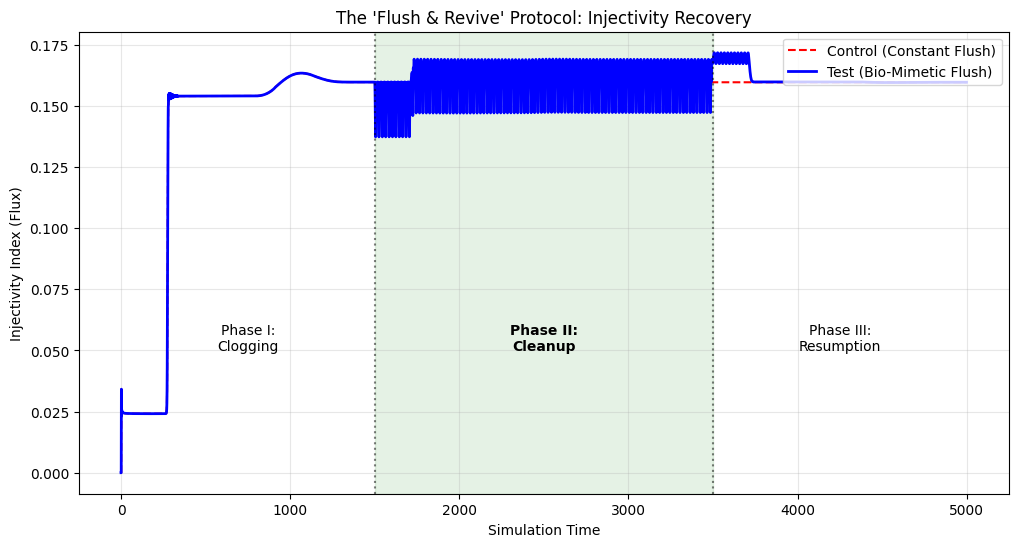

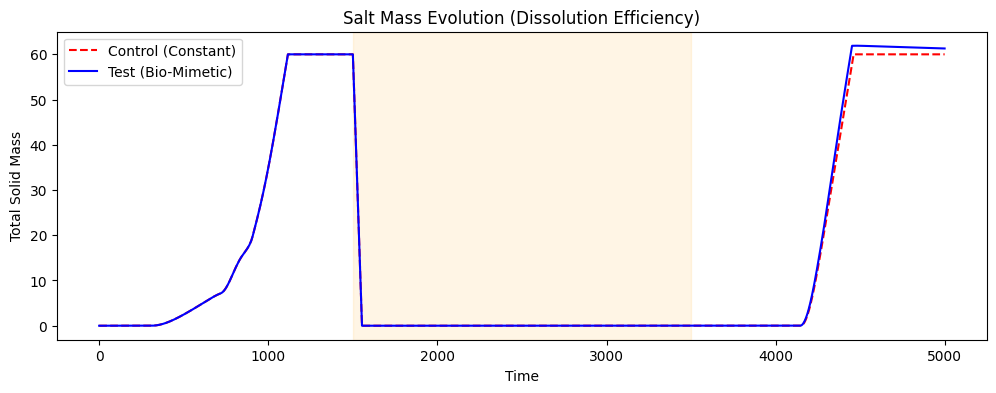

In [11]:
plt.figure(figsize=(12, 6))

# --- Flux Recovery Plot ---
plt.plot(flux_ctrl, 'r--', label='Control (Constant Flush)', linewidth=1.5)
plt.plot(flux_test, 'b-', label='Test (Bio-Mimetic Flush)', linewidth=2)

# Annotate Phases
plt.axvline(1500, color='k', linestyle=':', alpha=0.5)
plt.axvline(3500, color='k', linestyle=':', alpha=0.5)
plt.text(750, 0.05, "Phase I:\nClogging", ha='center')
plt.text(2500, 0.05, "Phase II:\nCleanup", ha='center', fontweight='bold')
plt.text(4250, 0.05, "Phase III:\nResumption", ha='center')

# Highlight Cleanup Zone
plt.axvspan(1500, 3500, color='green', alpha=0.1)

plt.title("The 'Flush & Revive' Protocol: Injectivity Recovery")
plt.ylabel("Injectivity Index (Flux)")
plt.xlabel("Simulation Time")
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)
plt.show()

# --- Mass Removal Plot ---
plt.figure(figsize=(12, 4))
plt.plot(mass_ctrl, 'r--', label='Control (Constant)')
plt.plot(mass_test, 'b-', label='Test (Bio-Mimetic)')
plt.axvspan(1500, 3500, color='orange', alpha=0.1)
plt.title("Salt Mass Evolution (Dissolution Efficiency)")
plt.ylabel("Total Solid Mass")
plt.xlabel("Time")
plt.legend()
plt.show()